# Аналитика в Яндекс.Афише

Я прохожу стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.


**В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:**
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.


**Предстоит изучить:**
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

# Шаг 1. Открою файлы с данными и изучу общую информацию

#### 1.1. Импортирую необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import math


#### 1.2. Открою датафреймы

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_log.csv')
    orders = pd.read_csv('/datasets/orders_log.csv')
    costs = pd.read_csv('/datasets/costs.csv')
except:
    visits = pd.read_csv('D:/repository/projects/6_анализ бизнес показателей/visits_log.csv')
    orders = pd.read_csv('D:/repository/projects/6_анализ бизнес показателей/orders_log.csv')
    costs = pd.read_csv('D:/repository/projects/6_анализ бизнес показателей/costs.csv')

In [3]:
for data in [visits, orders, costs]: print(data.head(), end='\n\n')

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  

                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-

# Описание данных


Таблица **visits** (лог сервера с информацией о посещениях сайта):

- **Uid** — уникальный идентификатор пользователя
- **Device** — категория устройства пользователя
- **Start Ts** — дата и время начала сессии
- **End Ts** — дата и время окончания сессии
- **Source Id** — идентификатор рекламного источника, из которого пришел пользователь


Таблица **orders** (информация о заказах):

- **Uid** — уникальный id пользователя, который сделал заказ
- **Buy Ts** — дата и время заказа
- **Revenue** — выручка Яндекс.Афиши с этого заказа


Таблица **costs** (информация о затратах на маркетинг):

- **source_id** — идентификатор рекламного источника
- **dt** — дата
- **costs** — затраты на этот рекламный источник в этот день

#### 1.3. Изучу общую информацию

In [4]:
for data in [visits, orders, costs]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None



# Промежуточный итог:

Названия столбцов необходимо привести к нижнему регистру и убрать пробелы. Во всех трёх фреймамх у столбцов с датой изменить тип на datetime. 

#### Таблица visits

In [5]:
visits.columns = ['device', 'end_ts','source_id','start_ts','uid']
visits['end_ts'] = visits['end_ts'].astype('datetime64')
visits['start_ts'] = visits['start_ts'].astype('datetime64')

#### Таблица orders

In [6]:
orders.columns = ['buy_ts', 'revenue','uid']
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

#### Таблица costs

In [7]:
costs['dt'] = costs['dt'].astype('datetime64')

# Итог:

Все столбцы имеют подходящий для анализа тип, названия столбцов приведены к удобному для анализаа виду, пропуски в данных отсутствуют. Можно приступать к анализу.

# Шаг 2. Формирование отчётов и подсчёт метрик

## Шаг 2.1. Продукт

#### Шаг 2.1.1. Сколько людей пользуются в день, неделю, месяц?

In [8]:
visits['start_ts_day'] = visits['start_ts'].dt.date
visits['start_ts_week'] = visits['start_ts'].dt.week
visits['start_ts_month'] = visits['start_ts'].dt.month
visits['start_ts_year'] = visits['start_ts'].dt.year

In [9]:
dau = visits.groupby(['start_ts_year', 'start_ts_day']).agg({'uid':'nunique'})
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'})
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'})

In [10]:
print('Среднее количество пользователей в день: ', int(dau.mean()))
print('Среднее количество пользователей в неделю: ', int(wau.mean()))
print('Среднее количество пользователей в месяц: ', int(mau.mean()))

Среднее количество пользователей в день:  907
Среднее количество пользователей в неделю:  5716
Среднее количество пользователей в месяц:  23228


Визуализирую полученые данные, сделаю разбивку по устройствам

In [11]:
def getPlt(chuck):
    table = pd.DataFrame(chuck).reset_index()
    x = table.index
    y = table['uid']
    y2= table['desktop']
    y3= table['touch']
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y)
    ax.plot(x,y2)
    ax.plot(x,y3)
    plt.legend(['all', 'desktop', 'touch'])
    plt.show()

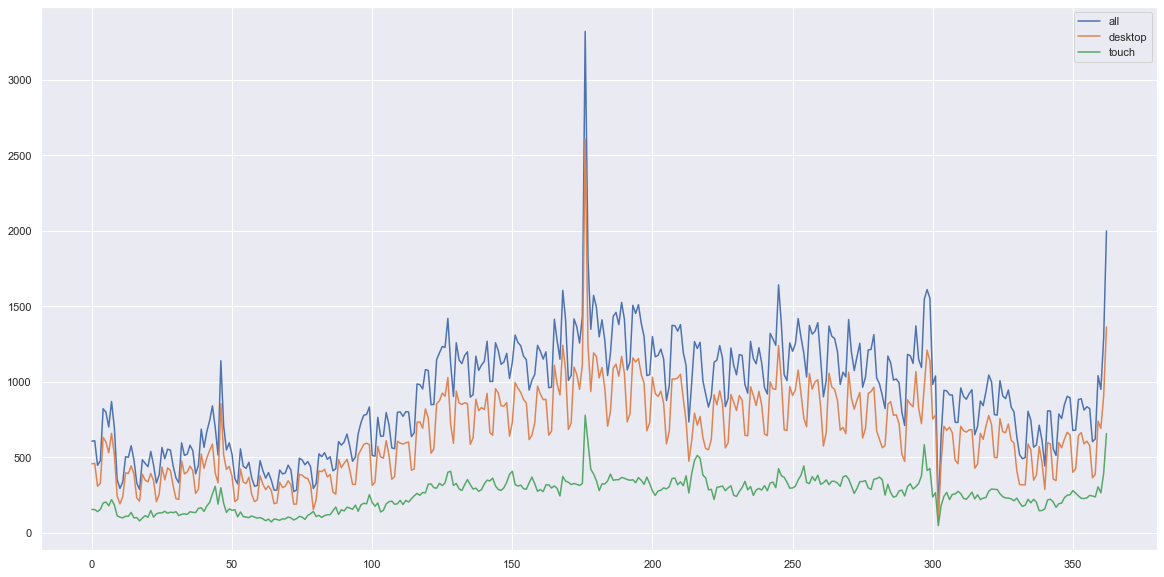

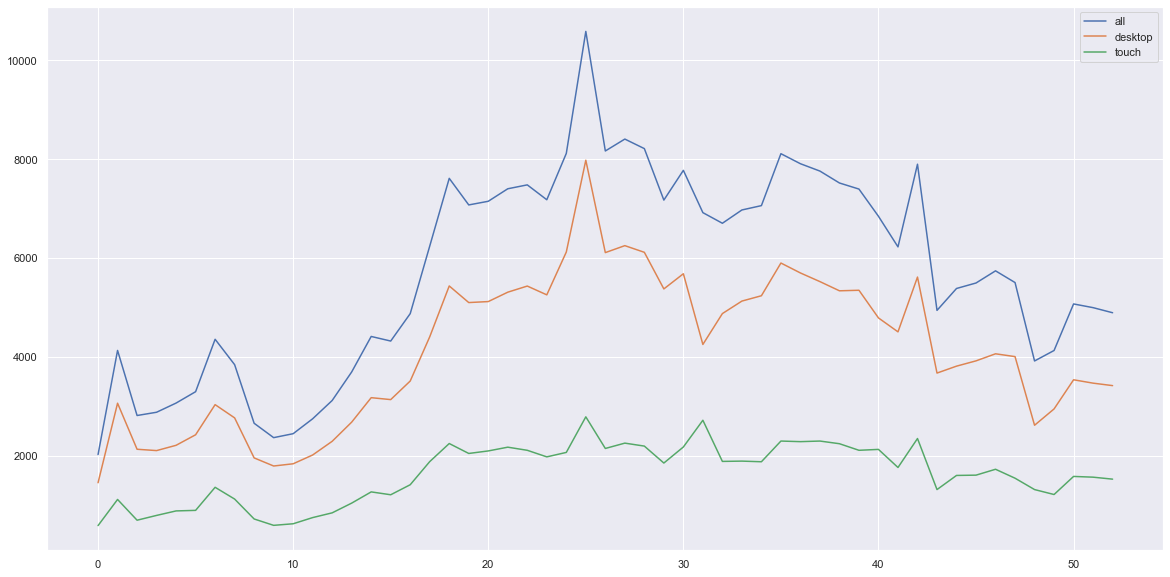

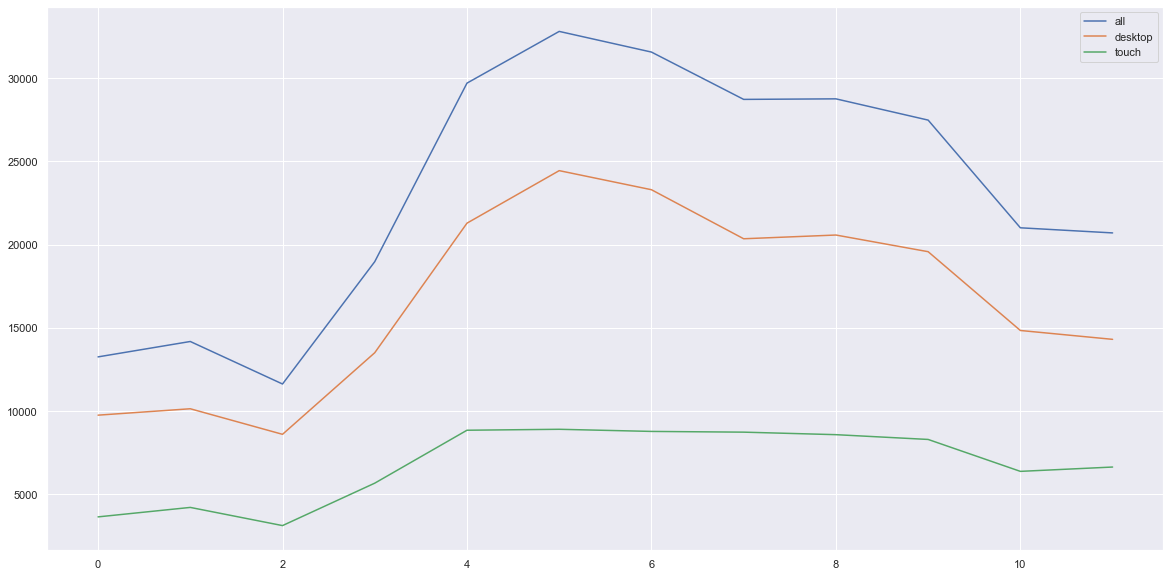

In [12]:
columns = ['start_ts_day', 'start_ts_week', 'start_ts_month']
metrics = [dau, wau, mau]

for i in range(len(columns)):
    desktop_dev = pd.DataFrame(visits[visits['device'] == 'desktop'].groupby([columns[i], 'start_ts_year'])
                      .agg({'uid':'nunique'})).reset_index().rename(columns={'uid':'desktop'})
    touch_dev = pd.DataFrame(visits[visits['device'] == 'touch'].groupby([columns[i], 'start_ts_year'])
                      .agg({'uid':'nunique'})).reset_index().rename(columns={'uid':'touch'})
    final_df = pd.merge(desktop_dev, touch_dev, on=[columns[i], 'start_ts_year'])
    getPlt(pd.merge(metrics[i], final_df, on=[columns[i], 'start_ts_year']))

#####
dau = dau.mean()
wau = wau.mean()
mau = mau.mean()

Графики между собой очень похожи, подъём и спад не зависит от устройсктва, но преимущественно пользуются с десктопной версией, видимо приложение на смартфоне не очень удобное. Возможно есть смысл провести отдельное исследование, в рамках которого выявить "больные" места приложения, возможно так получится привлечь клиентов и популярность ресурса повысится. 

По графикам прослеживается сезонность: с августа по ноябрь активность пользователей возрастает. Возможно связано с началом театрального сезона. 

Судя по цифрам продукт не сильно популярен, посещаемость небольшая.

In [13]:
sticky_wau = dau / wau 
sticky_mau = dau / mau 
print('Недельная вовлеченность аудитории: {:.2%}'.format(sticky_wau[0]))
print('Месячная вовлеченность аудитории: {:.2%}'.format(sticky_mau[0]))

Недельная вовлеченность аудитории: 15.88%
Месячная вовлеченность аудитории: 3.91%


Вовлечённость так же небольшая

#### Шаг 2.1.2. Сколько сессий в день?

In [14]:
day_visits = visits.groupby(['start_ts_day']).agg({'uid':'count'})
print('Среднее количество сессий в день: ', int(day_visits.mean()[0]))

Среднее количество сессий в день:  987


In [15]:
sessions_per_day = visits.groupby(['start_ts_year','start_ts_day']).agg({'uid': ['count','nunique']})
sessions_per_day.columns = ['n_sessions', 'n_users']
sessions_per_day['sess_per_user'] = sessions_per_day['n_sessions'] / sessions_per_day['n_users']
print('Количество сессий в день на одного человека: ', sessions_per_day['sess_per_user'].mean())

Количество сессий в день на одного человека:  1.082169644003972


#### Шаг 2.1.3. Сколько длится одна сессия (без учёта нулевых сессий)? 

In [16]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
duration_session = visits[visits['duration'] != 0]['duration'].mode()
#rкоммент по частовстречающемуся
print('Средняя одной сессии составляет: ', duration_session[0], 'секунд')


Средняя одной сессии составляет:  60 секунд


Знаечения считал по моде, т.к. встречаются подозрительно длинные сессии и по этому считать среднее не верно, т.к. это сильно повлияет на результат. Логично взять самые частовстречающиеся значения.

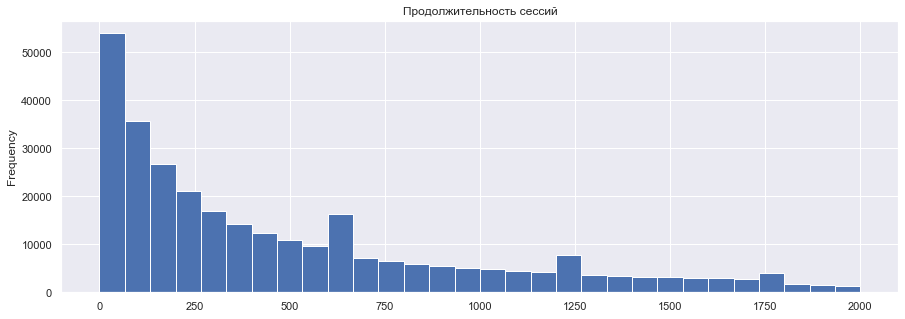

In [17]:


hist_duration_session = visits[visits['duration'] != 0]['duration']
hist_duration_session.plot(grid = True, kind = 'hist', bins = 30, figsize = (15,5), range = (0, 2000),
                           title = "Продолжительность сессий")
plt.show()

In [18]:
visits[visits['duration'] != 0]['duration'].describe()

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: duration, dtype: float64

Получается сессии в большинстве своём короткие - до 2 минут. Можно сказать, что пользоваатель попав на сайт почти сразу уходит. 

#### Шаг 2.1.4. Как часто люди возвращаются?

Выделю дату, когда пользователь впервые проявил активность, добавим информацию в таблицу visits

In [19]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')

Для удобства работы создам новый датафрейм, где оставлю только необходимые для анализа столбцы. 

In [20]:
retrate_visits = pd.DataFrame(visits[[ 'uid', 'start_ts', 'first_activity_date']])

Добавлю солбцы с информацией когда была начата сессия и когда была начата первая сессия.

In [21]:
retrate_visits['first_activity_month'] = retrate_visits['first_activity_date'].astype('datetime64[M]')
retrate_visits['start_month'] = retrate_visits['start_ts'].astype('datetime64[M]')

In [22]:
retrate_visits

,uid,start_ts,first_activity_date,first_activity_month,start_month
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,16174680259334210214,2018-05-20 10:59:00,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-01,2017-12-01
...,...,...,...,...,...
359395,18363291481961487539,2017-07-29 19:07:00,2017-07-29 19:07:00,2017-07-01,2017-07-01
359396,18370831553019119586,2018-01-25 17:38:00,2018-01-25 17:38:00,2018-01-01,2018-01-01
359397,18387297585500748294,2018-03-03 10:12:00,2018-03-03 10:12:00,2018-03-01,2018-03-01
359398,18388616944624776485,2017-11-02 10:12:00,2017-11-02 10:12:00,2017-11-01,2017-11-01


Расчитаю время жизни когорты.

In [23]:
retrate_visits['cohort_lifetime'] = ((retrate_visits['start_month'] - \
                                     retrate_visits['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')

Группирую данные по когорте и lifetime. Найду количество активных пользователей для каждой когорты на определённый месяц

In [24]:
cohorts = retrate_visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Найду исходное количество пользователей в когорте, взяв их число на нулевую неделю

In [25]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Наконец, для подсчёта Retenrion Rate, необходимо объединить данные по когортам с с исходным количеством пользователей в когорте

In [26]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


Составлю тепловую карту, для лучшего восприятия полученых данных 

In [27]:
retention_pivot = cohorts.pivot_table(index='first_activity_month', 
                                      columns='cohort_lifetime', 
                                      values='retention', 
                                      aggfunc='sum').reset_index()
retention_pivot['first_activity_month'] = retention_pivot['first_activity_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_activity_month')

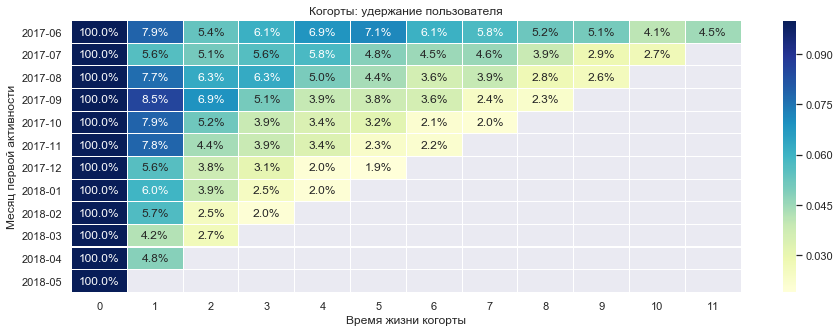

In [28]:
plt.figure(figsize=(15,5))
plt.title('Когорты: удержание пользователя')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=0.02, cmap="YlGnBu", vmax=.1)
plt.ylabel('Месяц первой активности')
plt.xlabel('Время жизни когорты')
sns.set(style='white')
plt.show()

## Вывод:

Когортный анализ показал, что уже на второй месяц посещаемость падает более чем на 90% для каждой когорты. Лишь не многие пользуются сервисом на постоянной основе. Следовательно основную часть прибыли компания получает в первый месяц жизни когорты.  Можно предположить, что основная масса людей не так часто посещает какие-то мероприятия, т.е. к сервису обращаются крайне редко, отсюда и такой низкий коэффициент удержания. 

Но на "Яндекс.Афиша" можно приобретать билеты не только на концерты, но и театы, кинотеаты, выставки и тд. Отсюда можно выдвинуть ещё одно предположение - возможно сервис не достаточно рекламируют. 

Так же выяснил, что присутствует сезонная активность, предпогалаю, что это связано с началом театрального сезона. Мобильным приложение пользуются гораздо реже, десктопная версия сервиса более популярна. Ранее уже высказал мнение, что стоит отдельно иссндовать приложение, возможно так можно будет повысить популярность сервиса

## Шаг 2.2. Продажи

#### Шаг 2.2.1. Когда люди начинают покупать?

Из таблицы visits выделю дату первой сессии и объединю с датафреймом orders_copy

In [29]:
orders_copy = orders.copy()

In [30]:
# дата первой сесии
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min'})
first_sessions.columns = ['first_activity']


# время первой покупки
first_orders = orders_copy.groupby(['uid']).agg({'buy_ts':'min'})
first_orders.columns = ['first_buy_ts']



# добавлю дату и время первой сессии в информацию по первым заказам
first_orders = first_orders.join(first_sessions,on='uid')

В таблице orders выделю дату первой покупки

In [31]:
first_order_date = orders_copy.groupby(['uid'])['buy_ts'].min().reset_index()
first_order_date.columns = ['uid', 'first_order_date']

В таблице visits выдел. дату первой активности, соеденю её с датой первой покупки по столбцу uid

In [32]:
first_session_date = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_session_date.columns = ['uid', 'first_session_date']

In [33]:
first_order = first_order_date.merge(first_session_date, on='uid')
first_order.head()

,uid,first_order_date,first_session_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Посчитаю сколько времени прошло от первой активности до первой покупки

In [34]:
first_order['time_to_buy'] = (first_order['first_order_date'] - first_order['first_session_date'])/np.timedelta64(1, 'm')

In [35]:
first_order['time_to_buy'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: time_to_buy, dtype: float64

In [36]:
print('Среднее количество дней от первой активности до первой покупки: ', int(first_order['time_to_buy'].mean()/60/24))
print('Медианное количество минут от первой активности до первой покупки: ', int(first_order['time_to_buy'].median()))
print('Мода минут от первой активности до первой покупки: ', int(first_order['time_to_buy'].mode()))

Среднее количество дней от первой активности до первой покупки:  16
Медианное количество минут от первой активности до первой покупки:  16
Мода минут от первой активности до первой покупки:  1


Наблюдается довольно большой разброс, чтобы что-то сказать, попробую визуализировать полученые данные

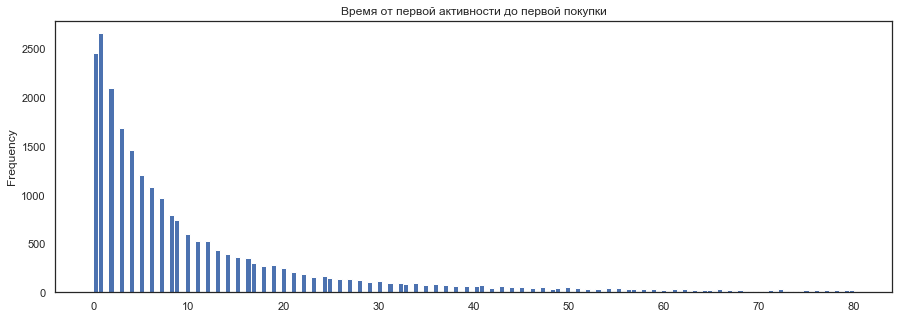

In [37]:
first_order['time_to_buy'].plot(kind='hist', bins=150, range=(0,80),
                               figsize=(15,5), title='Время от первой активности до первой покупки')
plt.show()

Проведу категоризацию: разделю покупателей на 2 группы, тех кто совершает покупку до 10 минут и тех кто тратит на покупку больше 10 минут.

In [38]:
first_order_fin = pd.DataFrame(first_order[['uid', 'time_to_buy']])
first_order_fin = pd.DataFrame(first_order_fin[first_order_fin['time_to_buy'] != 0])


In [39]:
def firt_order_time(time_to_buy):
    if  time_to_buy < 600:
        return 'before_10_min'
    if time_to_buy > 600:
        return 'after_10_min'

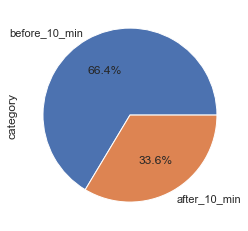

In [40]:
first_order_fin['category'] = first_order_fin['time_to_buy'].apply(firt_order_time)
first_order_fin['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

66.4 процентов пользователей совершили покупку в интервале до 10 минут. Это говорит о том, что оосновная масса поукпателей знает, что хочет приобрести и не занимается поиском каки-то мероприятий.

#### Шаг 2.2.2. Сколько раз покупают за период?

В таблице orders не хватает столбцов с датой первой сессии и датой первой покупки

In [41]:
orders_copy = orders_copy.join(first_orders, on='uid')

In [42]:
#orders = orders.join(first_orders, on='uid')

Выделю столбцы с датой первого заказа и месяцев первого заказа

In [43]:
orders_copy['first_buy_month'] = orders_copy['first_buy_ts'].astype('datetime64[M]')
orders_copy['first_session_month'] = orders_copy['first_activity'].astype('datetime64[M]')
orders_copy['buy_month'] = orders_copy['buy_ts'].astype('datetime64[M]')

In [44]:
#orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')
#orders['first_session_month'] = orders['first_activity'].astype('datetime64[M]')
#orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

Проведу когортный анализ по дате первой сессии

Добавлю столбец с разницей по времени между покупкой и первой покупкой 

In [45]:
orders_copy['lifetime'] = ((orders_copy['buy_month'] - orders_copy['first_session_month']) / np.timedelta64(1, 'M')).round().astype('int')

Группирую данные по когорте и lifetime. Найду количество покупок и пользователей для каждой когорты 

In [46]:
orders_cohorts = orders_copy.groupby(['first_session_month', 'lifetime']).agg({'uid':['count', 'nunique']}).reset_index()
orders_cohorts.columns = ['first_session_month', 'lifetime', 'n_orders', 'n_users']

Подсчитаю количество заказов на одного пользователя в каждой когорте и каждому lifetiem

In [47]:
orders_cohorts['orders_per_user'] = orders_cohorts['n_orders'] / orders_cohorts['n_users']
orders_cohorts['first_session_month'] = orders_cohorts['first_session_month'].dt.strftime('%Y-%m')

Составлю тепловую карту, для лучшего восприятия полученых данных 

In [48]:
orders_pivot = orders_cohorts.pivot_table(index='first_session_month',
                                         columns='lifetime',
                                         values='orders_per_user',
                                         aggfunc = 'mean')

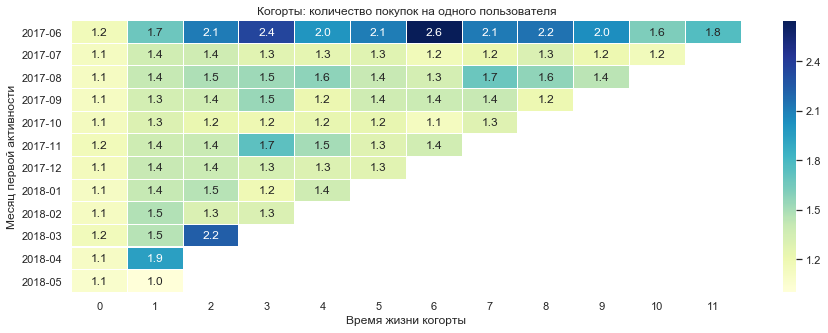

In [49]:
plt.figure(figsize=(15, 5))
plt.title('Когорты: количество покупок на одного пользователя')
sns.heatmap(orders_pivot, annot=True, fmt=".1f", linewidths=.02, cmap="YlGnBu")
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первой активности')
plt.show()

Опять у первой когорты, у которой **Retenrion Rate** самый высокий, имеет лучшие показатели, по сравнению с другими когортами. Эти пользователи покупают в среднем по 2  билета. Остальные коготы ведут себя очень похоже, на одного клиента приходится примерно по 1.4 билета.  

Из аномалий можно отметить 2018-03 и 2018-04, их покупательская способность увеличилась со временем. Есть смысл в этих когортах увеличить рекламу, чтобы и дальше стимулировать их к покупкам

#### Шаг 2.2.3. Какой средний чек?

Группирую заказы по когортам и lifetime. Нахожу сумму покупок на одного пользователя

In [50]:
orders_by_cohorts = orders_copy.groupby(['first_session_month', 'lifetime']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_by_cohorts.columns = ['first_session_month', 'lifetime', 'revenue_total', 'n_users']
orders_by_cohorts['revenue_per_user'] = orders_by_cohorts['revenue_total'] / orders_by_cohorts['n_users']
orders_by_cohorts['first_session_month'] = orders_by_cohorts['first_session_month'].dt.strftime('%Y-%m')

Составлю тепловую карту, чтобы увидеть средний чек по каждой когорте

In [51]:
average_check = orders_by_cohorts.pivot_table(index = 'first_session_month', 
                                              columns = 'lifetime', 
                                              values = 'revenue_per_user', 
                                              aggfunc = 'mean')


Средний чек равен 5.00 тысяч рублей


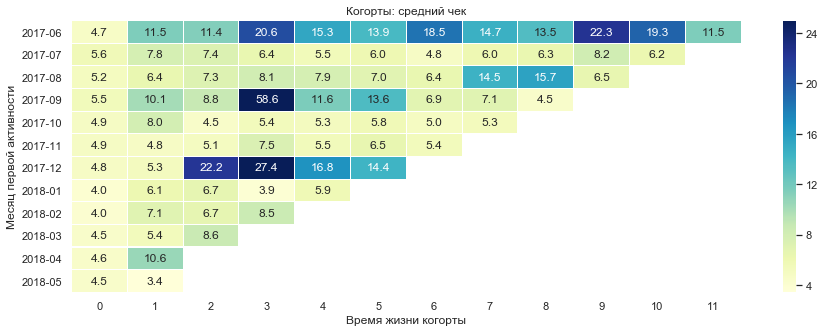

In [52]:
plt.figure(figsize=(15, 5))
plt.title('Когорты: средний чек')
sns.heatmap(average_check, annot=True, fmt=".1f", linewidths=.02, cmap="YlGnBu", vmax=25)
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первой активности')

print('Средний чек равен {:.2f} тысяч рублей'.format(orders['revenue'].mean()))


Снова первая когорта показывает себя на порядок лучше других. Из аномалий следует отметить сентябрьскую когорту, сильно выделяетяс на фоне других. Ранее я выявил некую сезонность, полагаю что такой резкий скачёк вызван как раз началом театрального сезона. Но это не объясняет почему такого не наблюдается в других когортах. 

#### Шаг 2.2.4. Сколько денег приносят? (LTV)

Создам таблицу с количеством покупателей в когорте

In [53]:
first_orders_chuck = orders_copy.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders_chuck.columns = ['uid', 'first_order_month']

In [54]:
cohort_sizes_chuck = first_orders_chuck.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_chuck.columns = ['first_order_month', 'n_buyers']

In [55]:
cohort_buyers_sizes = orders_copy.groupby(['first_buy_month']).agg({'uid':'nunique'}).reset_index()
cohort_buyers_sizes.columns = ['first_buy_month', 'n_buyers']

In [56]:
orders_chuck = pd.merge(orders, first_orders_chuck, on ='uid')
orders_chuck['order_month'] = orders_chuck['buy_ts'].dt.strftime('%Y-%m')
orders_chuck['first_order_month'] = orders_chuck['first_order_month'].dt.strftime('%Y-%m')

Создам сводную таблицу с группировкой по месяцу первой покупки и месяцем каждой покупки, сложив выручки

In [57]:
b_cohorts = orders_copy.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum'}).reset_index()

Соединю полученые таблицы

In [58]:
report = pd.merge(cohort_buyers_sizes, b_cohorts, on=['first_buy_month'])

Поскольку LTV считается не из выручки, а из валовой прибыли - нужно найти валовую прибыль, умножив выручку на маржинальность. Посколько в заданиии не указано, какого размера маржинальность, то возьму значение в 70%

Расчитаю валовую прибыль, возраст когорты и ltv

In [59]:
margin_rate = .7

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['buy_month']-report['first_buy_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']
report['first_buy_month'] = report['first_buy_month'].dt.strftime('%Y-%m-%d')
report['buy_month'] = report['buy_month'].dt.strftime('%Y-%m-%d')
report


,first_buy_month,n_buyers,buy_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,6690.243,0,3.307090
1,2017-06-01,2023,2017-07-01,981.82,687.274,1,0.339730
2,2017-06-01,2023,2017-08-01,885.34,619.738,2,0.306346
3,2017-06-01,2023,2017-09-01,1931.30,1351.910,3,0.668270
4,2017-06-01,2023,2017-10-01,2068.58,1448.006,4,0.715772
...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,780.409,2,0.220891
75,2018-04-01,2276,2018-04-01,10600.69,7420.483,0,3.260318
76,2018-04-01,2276,2018-05-01,1209.92,846.944,1,0.372120
77,2018-05-01,2988,2018-05-01,13925.76,9748.032,0,3.262394


Составлю тепловую карту

In [60]:
output = report.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)

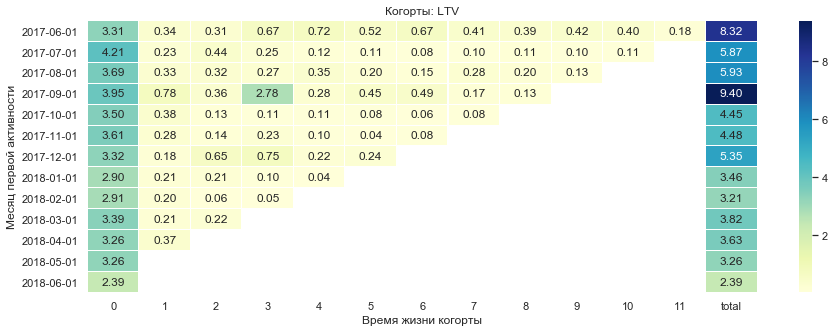

In [61]:
plt.figure(figsize=(15, 5))
plt.title('Когорты: LTV')
output['total'] = output.sum(axis=1).round(2)
sns.heatmap(output, annot=True, fmt=".2f", linewidths=.02, cmap="YlGnBu")
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первой активности')
plt.show()

Можно сказать, что картина вновь повторяется, первая когорта самая стабильная и принесла болье всего денег, в среднем каждый покупатель этой когорты принёс по 8.32 т.р.. Сентябрьская когорта вновь выделилась, полагаю на фоне большого среднего чека в третий месяц жизни.

## Вывод: 

Среднее количество дней от первой активности до первой покупки:  16. Видимо пользователи сначала изучают цены, а потом уже покупают, такое предположение строю, т.к. 66.4 всех покупателей совершают покупки быстро, т.е. они знают что им нужно. 

Первая когорта имеет лучшие показатели, по сравнению с другими когортами. Эти пользователи покупают в среднем по 2 билета, средний чек Остальные коготы ведут себя очень похоже, на одного клиента приходится примерно по 1.4 билета.

Из аномалий можно отметить 2018-03 и 2018-04, их покупательская способность увеличилась со временем. Есть смысл в этих когортах увеличить рекламу, чтобы и дальше стимулировать их к покупкам. 

Подводя итог можно сказать, что особое внимание следует уделить первой, четвёртой и седьмой когортам. В последней наблюдался скачок по среднему чеку на 2 месяца, правда потом показатели начали падать. 

## Шаг 2.3. Маркетинг

#### Шаг 2.3.1. Сколько денег потратили? 

In [62]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
print('Всего потрачено на маркетинг {} рублей'.format(costs['costs'].sum()))

Всего потрачено на маркетинг 329131.62 рублей


Расходы на каждый источник отоброжу в виде круговой диаграммы

In [63]:
costs_group = pd.DataFrame(costs.groupby('source_id').sum()).reset_index()

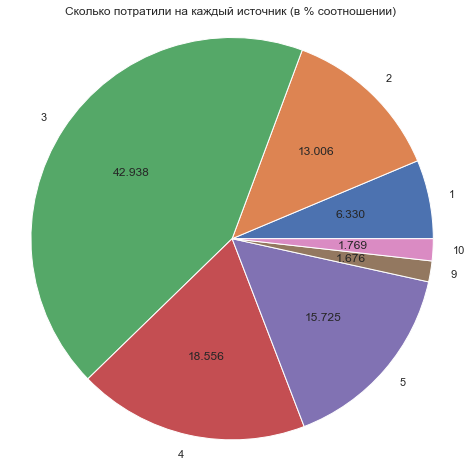

In [64]:
labels = costs_group['source_id']
vals = costs_group['costs']

fig, ax = plt.subplots(figsize=(8,8))


ax.set_title('Сколько потратили на каждый источник (в % соотношении)')

ax.pie(vals, autopct='%.3f', shadow=False,labels=labels)

ax.axis('equal')


plt.show()

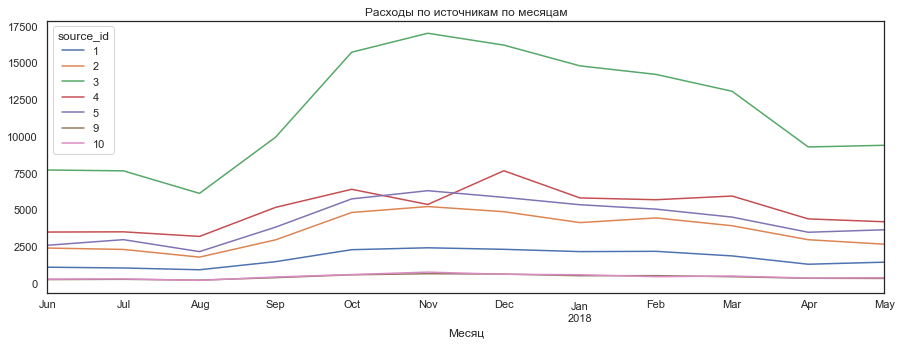

In [65]:
costs_pivot = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_pivot.plot(figsize = (15,5), title = 'Расходы по источникам по месяцам')
plt.xlabel('Месяц')
plt.show()

Среди всех рекламных источников выделяется только третий, он самый затратный, а в период максимальной активности (как я уже выяснил, он начинается в августе) затраты на этот источник возрастают в 2.5 раза.  Остальные источники в динамике ведут себя примерно одинаково. В сезон так же затраты на эти источники увеличиваются. Можно сделать вывод, что посещаемость ресурса можно поднять более активной рекламой.

Рассчитаю CAC для каждой когорты

In [66]:
try:
    visitsss =  pd.read_csv('/datasets/visits_log.csv')
except:
    visitsss = pd.read_csv('D:/repository/projects/6_анализ бизнес показателей/visits_log.csv')
visitsss.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visitsss.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [67]:
tb1 = visitsss.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'}).reset_index()\
    .rename(columns={'start_ts':'first_vis_month'})
tb1['first_vis_month'] = tb1['first_vis_month'].astype('datetime64[M]')
tb1.head()

,uid,first_vis_month,source_id
0,11863502262781,2018-03-01,3
1,49537067089222,2018-02-01,2
2,297729379853735,2017-06-01,3
3,313578113262317,2017-09-01,2
4,325320750514679,2017-09-01,5


In [68]:
tb2 = orders.copy()
tb2['buy_ts'] = tb2['buy_ts'].astype('datetime64[M]')
tb2 = tb2.groupby(['uid', 'buy_ts']).agg({'revenue':'sum'}).reset_index()
tb2.columns = ['uid', 'buy_month', 'revenue']
tb2.head()

,uid,buy_month,revenue
0,313578113262317,2018-01-01,0.55
1,1575281904278712,2017-06-01,3.05
2,2429014661409475,2017-10-01,73.33
3,2464366381792757,2018-01-01,2.44
4,2551852515556206,2017-11-01,10.99


In [69]:
tb4= pd.merge(tb1,tb2, on=['uid'])
tb4.head()

,uid,first_vis_month,source_id,buy_month,revenue
0,313578113262317,2017-09-01,2,2018-01-01,0.55
1,1575281904278712,2017-06-01,10,2017-06-01,3.05
2,2429014661409475,2017-10-01,3,2017-10-01,73.33
3,2464366381792757,2018-01-01,5,2018-01-01,2.44
4,2551852515556206,2017-11-01,5,2017-11-01,10.99


tb41 -месяц первой покупки, tb411 - cohort_sizes (количество новых покупателей)

In [70]:
tb41 = tb4[['uid', 'buy_month', 'source_id' ]].drop_duplicates() 
tb41 = tb41.groupby(['uid', 'source_id']).agg({'buy_month': 'min'}).reset_index().rename(columns={'buy_month':'first_buy_month'})


tb411 = tb41.groupby(['first_buy_month', 'source_id' ]).agg({'uid': 'nunique'}).reset_index()\
    .rename(columns={'uid':'n_buyers'}) 


tb422 - cohorts (по месяцу первой покупки, source_id и месяцу заказа и сложим выручку)

In [71]:
tb42 = tb4[['uid','source_id', 'buy_month', 'revenue']] #order_new
tb42 = pd.merge(tb42, tb41, on=['uid', 'source_id'])

tb422 = tb42.groupby(['first_buy_month','buy_month', 'source_id']).agg({'revenue': 'sum'}).reset_index()

In [72]:
monthly_costs = costs.groupby(['cost_month', 'source_id'])['costs'].sum().reset_index()\
    .rename(columns={'cost_month':'buy_month'})
monthly_costs['buy_month'] = monthly_costs['buy_month'].dt.strftime('%Y-%m')
monthly_costs.head()

,buy_month,source_id,costs
0,2017-06,1,1125.61
1,2017-06,2,2427.38
2,2017-06,3,7731.65
3,2017-06,4,3514.80
4,2017-06,5,2616.12


In [73]:
tb5_report = pd.merge(tb411, tb422, on=['first_buy_month','source_id'])
tb5_report['first_buy_month'] = tb5_report['first_buy_month'].astype('datetime64[M]')
tb5_report['buy_month'] = tb5_report['buy_month'].astype('datetime64[M]')
tb5_report

,first_buy_month,source_id,n_buyers,buy_month,revenue
0,2017-06-01,1,203,2017-06-01,1168.45
1,2017-06-01,1,203,2017-07-01,362.94
2,2017-06-01,1,203,2017-08-01,153.72
3,2017-06-01,1,203,2017-09-01,695.88
4,2017-06-01,1,203,2017-10-01,760.74
...,...,...,...,...,...
510,2018-05-01,4,767,2018-05-01,3616.23
511,2018-05-01,5,510,2018-05-01,2103.24
512,2018-05-01,9,53,2018-05-01,200.38
513,2018-05-01,10,117,2018-05-01,478.93


In [74]:
tb5_report['gp'] = tb5_report['revenue'] * margin_rate
tb5_report['age'] = (tb5_report['buy_month']-tb5_report['first_buy_month']) / np.timedelta64(1, 'M')
tb5_report['age'] = tb5_report['age'].round().astype('int')
tb5_report['ltv'] = tb5_report['gp'] / tb5_report['n_buyers']

In [75]:
monthly_costs['buy_month'] = monthly_costs['buy_month'].astype('datetime64[M]')
monthly_costs.columns = ['first_buy_month', 'source_id', 'costs']

report_new = tb5_report.merge(monthly_costs, on=['source_id','first_buy_month'])
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new[(report_new['first_buy_month'] == '2017-6') & (report_new['source_id'] == 1)]

,first_buy_month,source_id,n_buyers,buy_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,1,203,2017-06-01,1168.45,817.915,0,4.029138,1125.61,5.544877
1,2017-06-01,1,203,2017-07-01,362.94,254.058,1,1.251517,1125.61,5.544877
2,2017-06-01,1,203,2017-08-01,153.72,107.604,2,0.530069,1125.61,5.544877
3,2017-06-01,1,203,2017-09-01,695.88,487.116,3,2.399586,1125.61,5.544877
4,2017-06-01,1,203,2017-10-01,760.74,532.518,4,2.623241,1125.61,5.544877
5,2017-06-01,1,203,2017-11-01,714.59,500.213,5,2.464103,1125.61,5.544877
6,2017-06-01,1,203,2017-12-01,972.68,680.876,6,3.354069,1125.61,5.544877
7,2017-06-01,1,203,2018-01-01,397.79,278.453,7,1.371690,1125.61,5.544877
8,2017-06-01,1,203,2018-02-01,448.50,313.950,8,1.546552,1125.61,5.544877
9,2017-06-01,1,203,2018-03-01,630.44,441.308,9,2.173931,1125.61,5.544877


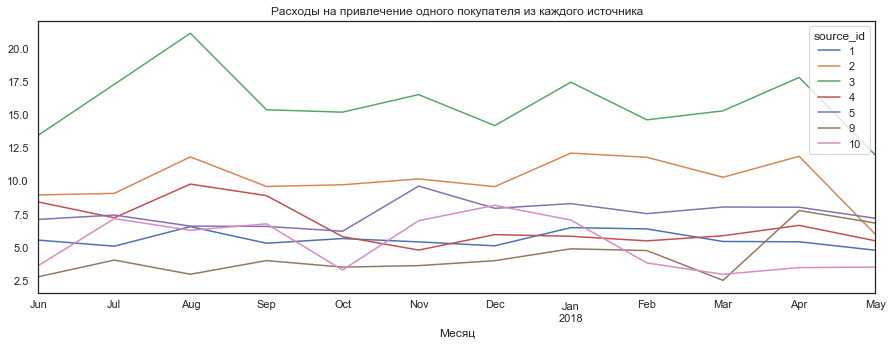

In [76]:
report_pivot = report_new.pivot_table(index = 'first_buy_month', columns = 'source_id', values = 'cac')
report_pivot.plot(figsize = (15,5), title = 'Расходы на привлечение одного покупателя из каждого источника')
plt.xlabel('Месяц')
plt.show()

Самыми дорогими источниками оказались третий и второй. Интересно, что в сезон (начиная с сентября и заканчивая в декабре) затраты на них немного упали, а в декабре вновь поднялись, опять же не много. В  динамике 3 и 2 источник очень похожи.

Остальные источники не сильно колеблятся, следовательно с выявленной сезонностью затраты никак не связаны. Других взаимосвязей так же не замечаю. 

Из аномалий стоит отметить 9 источник, в марте 2018 года наблюдается резкий скачок. 


Далее предстоит выяснить какие источники себя окупили. Возможно от 3го и 2го источников нужно будет отказаться, довольно много тратят, по ставнению с другими источниками.

Чтобы рассчитать накопиительный ROMI, вызову метод cumsum(), полученые значения усредним

In [77]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new

,first_buy_month,source_id,n_buyers,buy_month,revenue,gp,age,ltv,costs,cac,romi
0,2017-06-01,1,203,2017-06-01,1168.45,817.915,0,4.029138,1125.61,5.544877,0.726642
1,2017-06-01,1,203,2017-07-01,362.94,254.058,1,1.251517,1125.61,5.544877,0.225707
2,2017-06-01,1,203,2017-08-01,153.72,107.604,2,0.530069,1125.61,5.544877,0.095596
3,2017-06-01,1,203,2017-09-01,695.88,487.116,3,2.399586,1125.61,5.544877,0.432757
4,2017-06-01,1,203,2017-10-01,760.74,532.518,4,2.623241,1125.61,5.544877,0.473093
...,...,...,...,...,...,...,...,...,...,...,...
508,2018-05-01,3,785,2018-05-01,2990.65,2093.455,0,2.666822,9411.42,11.989070,0.222438
509,2018-05-01,4,767,2018-05-01,3616.23,2531.361,0,3.300340,4214.21,5.494407,0.600673
510,2018-05-01,5,510,2018-05-01,2103.24,1472.268,0,2.886800,3669.56,7.195216,0.401211
511,2018-05-01,9,53,2018-05-01,200.38,140.266,0,2.646528,362.17,6.833396,0.387293


In [78]:
output_romi = report_new.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)


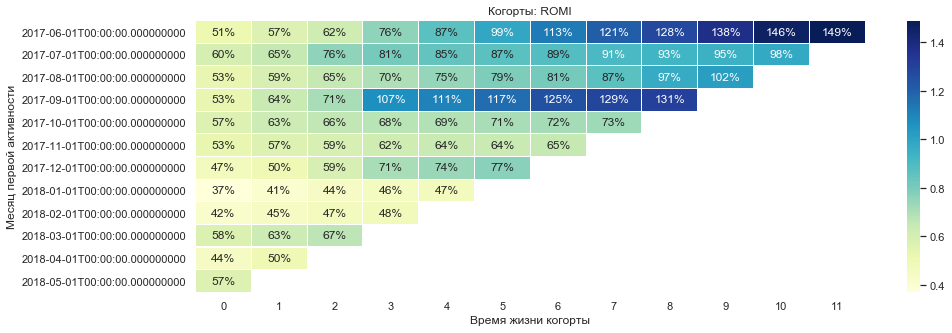

In [79]:
plt.figure(figsize=(15, 5))
plt.title('Когорты: ROMI')
sns.heatmap(output_romi, annot=True, fmt=".0%", linewidths=.02, cmap="YlGnBu")
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первой активности')
plt.show()

Всего окупились 3 когорты. Как и ожидалось первая показала себя лучше остальных, окупилась на седьмой месяц. 

Четвертая когорта из-за скачка окупилась на 4й месяц. Так же и 3я когорты приносит прибыть, хоть и не большую. Не сильно отстаёт и вторая, они близка к тому чтобы окупиться.

А вот остальные оставляют желать лучшего.

#### Шаг 2.3.2. Сколько стоило привлечение одного покупателя из каждого источника?

In [80]:
orders_group = orders.groupby('uid')['revenue'].sum().reset_index()

In [81]:
visits_copy = visits.copy()
visits_copy = visits_copy.merge(orders_group, on = 'uid')
visits_group = visits_copy.groupby('uid')['start_ts'].min().reset_index()
visits_final = visits_copy.merge(visits_group, on = ['uid','start_ts'], how = 'inner')

In [82]:
revenue_group = visits_final.groupby('source_id')['revenue'].sum().reset_index()
costs_group = costs.groupby('source_id')['costs'].sum().reset_index()
source_group = visits_final.groupby('source_id')['uid'].nunique().reset_index()
costs_group = costs_group.merge(source_group,on = 'source_id')
costs_group['cost_per_user'] = costs_group['costs'] / costs_group['uid']
costs_group = costs_group.merge(revenue_group,on = 'source_id')
costs_group

,source_id,costs,uid,cost_per_user,revenue
0,1,20833.27,2899,7.186364,31090.55
1,2,42806.04,3506,12.209367,46923.61
2,3,141321.63,10473,13.493901,54511.24
3,4,61073.60,10296,5.931779,56696.83
4,5,51757.10,6931,7.467479,52624.02
5,9,5517.49,1088,5.071222,5759.40
6,10,5822.49,1329,4.381106,4450.33


In [83]:
costs_group['gp'] = costs_group['revenue'] * margin_rate
costs_group['ltv'] = costs_group['gp'] / costs_group['uid']
costs_group['roi'] = costs_group['ltv'] / costs_group['cost_per_user'] *100
costs_group

,source_id,costs,uid,cost_per_user,revenue,gp,ltv,roi
0,1,20833.27,2899,7.186364,31090.55,21763.385,7.507204,104.464566
1,2,42806.04,3506,12.209367,46923.61,32846.527,9.368661,76.733393
2,3,141321.63,10473,13.493901,54511.24,38157.868,3.643452,27.000727
3,4,61073.60,10296,5.931779,56696.83,39687.781,3.854680,64.983530
4,5,51757.10,6931,7.467479,52624.02,36836.814,5.314791,71.172485
5,9,5517.49,1088,5.071222,5759.40,4031.580,3.705496,73.069095
6,10,5822.49,1329,4.381106,4450.33,3115.231,2.344041,53.503415


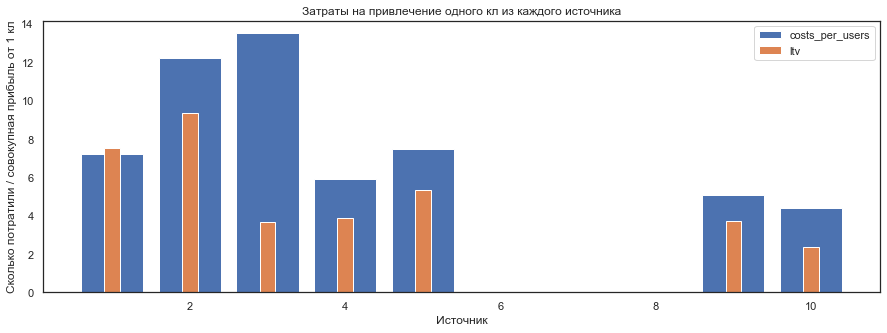

In [84]:
x = costs_group['source_id'] 
y = costs_group['cost_per_user'] 
y2 = costs_group['ltv']


fig, ax = plt.subplots(figsize=(15,5))
ax.bar(x,y)
ax.bar(x,y2, width=.2)
plt.legend(['costs_per_users', 'ltv'])

ax.set_title('Затраты на привлечение одного кл из каждого источника')
ax.set_xlabel('Источник')
ax.set_ylabel('Сколько потратили / совокупная прибыль от 1 кл')

plt.show()

Только кл из первого источника приносят прибыль. В остальных случаях компания терпит убытки. Самый не эффективный канал - третий. Остальные каналы можно развивать.

In [85]:
output_roi = costs_group.pivot_table(
        index='source_id', 
         
        values='roi', 
        aggfunc='mean').cumsum(axis=1).round(2)

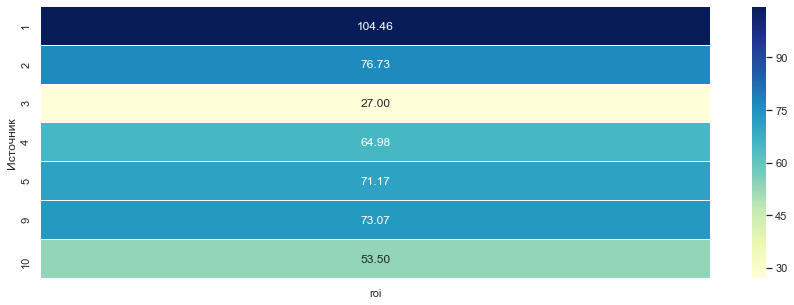

In [86]:
plt.figure(figsize=(15, 5))
sns.heatmap(output_roi, annot=True, fmt=".2f", linewidths=.02, cmap="YlGnBu")
plt.ylabel('Источник')
plt.show()

Ожидаемо окупается только первый источник, но всего то на 4.46% - что очень мало. 

Рассмотрю как распределяются заказы по платформам

In [87]:
device = visits_final.groupby('device')['uid'].count().reset_index()

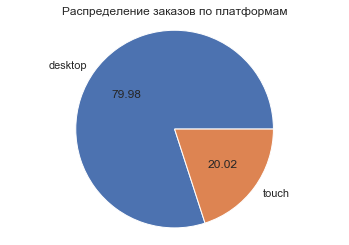

In [88]:
labels = device['device']
vals = device['uid']

fig, ax = plt.subplots()


ax.set_title('Распределение заказов по платформам')

ax.pie(vals, autopct='%.2f', shadow=False,labels=labels)

ax.axis('equal')


plt.show()

# Вывод:

В итоге узнал, что посещаемость ресурса не большая, в основном люди проводят на сайте 2 минуты. RR тоже маленький (около 4%), думаю стоит больше вкладывать в рекламу, информировать людей о мероприятиях чаще, возможно таким образом интерес к ресурсу вырастет. Большая часть клиентов после первой покупки уже не возвращаются. Остальные совершают в среднем 2 покупки в месяц.

Следует отметить первую когорту, её RR выше, чем у остальных когорт, средний чек значительно выше, чем у остальных когорт. Есть смысл провести более тщательное исследование (например интервью или опрос), чтобы подробнее узнать почему они выбирают Яндекс.Афишу, а не другие билетные агрегаторы. Полученые данные могут ответить на вопрос, как повысить популярность ресурса и как стимулировать больше клиентов к повторным покупкам.


# Маркетинг:


Самыми дорогими источниками оказались третий и второй. Интересно, что в сезон (начиная с сентября и заканчивая в декабре) затраты на них немного упали, а в декабре вновь поднялись, опять же не много. В динамике 3 и 2 источник очень похожи.

Остальные источники не сильно колеблятся, следовательно с выявленной сезонностью затраты никак не связаны. Других взаимосвязей так же не замечаю.

Из аномалий стоит отметить 9 источник, в марте 2018 года наблюдается резкий скачок.

От 3го рекламного источника следует отказаться, он слишком дорогой и не приносит прибыли. Средства, которые расходовались на 3й источник можно перераспределить в 1 (он единственный окупился), 2, 4, 5 и 9 источники. Следует так же отметить 2й источник, возможно есть смысл немного пересмотреть стратегию развития, т.к. он занимает второе место по затратности, среди всех источников и траты на него заметно выше, по сравнению с другими источниками.


Отдельно нужно отметить распределение заказов по платформам: почти 80% визитов производится с персонального компьютера, 20% - с мобильных устройств. Разница довольно большая, возможно из-за того что приложение отсутствует в Play Market, по запросу получил только приложения конкурирующих агрегаторов. Т.е. следует выпустить удобное приложение на андроид, ведь учитывая насколько сильно развилась мобильная индуствия, то гораздо удобнее покупать билеты в кинотеатр, театр и др мероприятия через телефон (возможно даже спонтанно, н.п. гуляя с друзьями совершить незапланированый поход в кинотеатр). Считаю что таким образом можно повысить RR, как следствие пересмотреть рекламную политику, с целью получения прибыли. Таким образом можно будет рассылать больше push-уведомлений, содержащий информацию об предстоящий мероприятиях (подобраных на основе просмотров или покупок). Или напонимание о уже запланированном мероприятии. 

И касаемо едсктопной версии, поскольку клиенты довольно мало проводят времени на сайте (в основном 2 минуты), есть смысл провести тест, который покажет возможные недочёты или выявит слабые места структуры сайта. На данный момент предполагаю, что сессии такие короткие, потому что ресурс не очень удобен в использовании.